# Multi-armed bandits

The objective of this lab session is to test the performance of some usual bandit algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Algorithms

There are $k$ possible actions, $a \in \{ 0, 1,...,k - 1\}$. 

We consider the following algorithms:
* $\varepsilon$-greedy
* adaptive greedy
* UCB
* Thompson sampling

Each algorithm returns an action based on the following inputs:

| Variable   |      Type      |  Description |
|:---|:---|:---|
| `cum_rewards` |    np.ndarray    |   cumulative reward of each action (R) |
| `nb_tries` |  np.ndarray  | number of tries of each action (N) |

**To do:**
* Code the UCB algorithm. 
* Observe the behaviour of the algorithms, for different parameters.
* Test the principle of "optimism in face of uncertainty" on the greedy policies.

**Note:** 
* Use the `simple_test` function to test the behaviour of the algorithms.
* You can enforce optimism by changing the initial values of R and N.

In [2]:
def eps_greedy(cum_rewards, nb_tries, eps = 0.1):
    k = len(nb_tries)
    active = np.where(nb_tries > 0)[0]
    if len(active) == 0 or np.random.random() < eps:
        return np.random.randint(k)
    else: 
        rewards = cum_rewards[active] / nb_tries[active]
        best_actions = np.where(rewards == np.max(rewards))[0]
        return active[np.random.choice(best_actions)]

In [3]:
def adaptive_greedy(cum_rewards, nb_tries, c = 1):
    k = len(nb_tries)
    active = np.where(nb_tries > 0)[0]
    t = np.sum(nb_tries)
    if len(active) == 0 or np.random.random() < c / (c + t):
        return np.random.randint(k)
    else:
        rewards = cum_rewards[active] / nb_tries[active]
        best_actions = np.where(rewards == np.max(rewards))[0]
        return active[np.random.choice(best_actions)]

In [82]:
#nb_tries: vecteur contenant le nb de fois qu'on a choisi de piocher l'arm   

def ucb(cum_rewards, nb_tries, c = 1):
    
    k = len(nb_tries)  #nb of arms
    a = np.where(nb_tries>0)[0] # index where nb_tries > 0
    
    n = sum(nb_tries) # sum of nb of tries
    k_reward = cum_rewards[a]/nb_tries[a]  #Mean reward for each arm
    print('k_reward: ',k_reward)
    
    upper_bound = np.argmax(k_reward[a] + c * np.sqrt((np.log(n)) / nb_tries[a])) # upper bound
    return upper_bound

In [83]:
def thompson(cum_rewards, nb_tries):
    try:
        # Beta prior (binary rewards)
        samples = np.random.beta(cum_rewards + 1, nb_tries - cum_rewards + 1)
    except:
        # Normal prior
        samples = np.random.normal(cum_rewards / (nb_tries + 1), np.sqrt(1. / (nb_tries + 1)))
    return np.argmax(samples)

In [84]:
def get_action(algo, cum_rewards, nb_tries):
    if algo == "eps_greedy":
        return eps_greedy(cum_rewards, nb_tries)
    elif algo == "adaptive_greedy":
        return adaptive_greedy(cum_rewards, nb_tries)
    elif algo == "ucb":
        return ucb(cum_rewards, nb_tries)
    elif algo == "thompson":
        return thompson(cum_rewards, nb_tries)

In [85]:
def get_bernoulli_reward(a, model_param):
    return float(np.random.random() < model_param[a])

In [86]:
# Simple test with binary rewards

def simple_test(algo, model_param = [0.6, 0.3, 0.1], time_horizon = 10, nb_tries = np.zeros(3), cum_rewards = np.zeros(3)):
    k = len(model_param)
    
    if (algo == "ucb"):
        for i in range(k):
            nb_tries[i] = 1
            cum_rewards [i] = get_bernoulli_reward(i, model_param)
            
        
    if nb_tries is None:
        nb_tries = np.zeros(k, int)
    if cum_rewards is None:
        cum_rewards = np.zeros(k, float)
    print("Parameters = ", model_param)
    print ("action -> reward")
    for t in range(time_horizon):
        a = get_action(algo, cum_rewards, nb_tries)
        r = get_bernoulli_reward(a, model_param)
        print(str(a) + " -> " + str(int(r)))
        cum_rewards[a] += r
        nb_tries[a] += 1
    active = np.where(nb_tries > 0)[0]
    rewards = cum_rewards[active] / nb_tries[active]
    best_actions = np.where(rewards == np.max(rewards))[0]
    print("Best action (estimation of the algorithm) = ", active[best_actions])

In [87]:
algos = ["eps_greedy", "adaptive_greedy", "ucb", "thompson"]

In [88]:
algo = algos[2]
simple_test(algo)

Parameters =  [0.6, 0.3, 0.1]
action -> reward
k_reward:  [1. 1. 0.]
0 -> 0
k_reward:  [0.5 1.  0. ]
1 -> 1
k_reward:  [0.5 1.  0. ]
1 -> 0
k_reward:  [0.5        0.66666667 0.        ]
0 -> 0
k_reward:  [0.33333333 0.66666667 0.        ]
1 -> 0
k_reward:  [0.33333333 0.5        0.        ]
2 -> 0
k_reward:  [0.33333333 0.5        0.        ]
1 -> 0
k_reward:  [0.33333333 0.4        0.        ]
0 -> 0
k_reward:  [0.25 0.4  0.  ]
2 -> 0
k_reward:  [0.25 0.4  0.  ]
1 -> 0
Best action (estimation of the algorithm) =  [1]


## Regret and precision

We now compare the performance of the algorithms in terms of **regret** and **precision**.

We consider two models: Bernoulli rewards and normal rewards. 

In [11]:
def get_reward(a, model, model_param):
    if model == "bernoulli":
        return float(np.random.random() < model_param[a])
    elif model == "normal":
        return np.random.normal(*model_param[a])

In [12]:
def simulate(model, model_param, time_horizon, algo):
    k = len(model_param)
    nb_tries = np.zeros(k, int)
    cum_rewards = np.zeros(k, float)
    action_seq = []
    reward_seq = []
    for t in range(time_horizon):
        a = get_action(algo, cum_rewards, nb_tries)
        r = get_reward(a, model, model_param)
        nb_tries[a] += 1
        cum_rewards[a] += r
        action_seq.append(a)
        reward_seq.append(r)
    return action_seq, reward_seq

In [13]:
# Bernoulli rewards
model = "bernoulli"
model_param = [0.6, 0.3, 0.1]
time_horizon = 10
algo = algos[0]

action_seq, reward_seq = simulate(model, model_param, time_horizon, algo)
print("actions = ", action_seq)
print("rewards = ", [int(r) for r in reward_seq])

actions =  [0, 0, 0, 0, 2, 0, 1, 0, 0, 0]
rewards =  [1, 0, 1, 0, 0, 1, 0, 0, 1, 0]


In [14]:
# Normal rewards
model = "normal"
model_param = [(2,1), (2.5,1)]
algo = algos[0]

action_seq, reward_seq = simulate(model, model_param, time_horizon, algo)
print("actions = ", action_seq)
print("rewards = ", [np.round(r,1) for r in reward_seq])

actions =  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
rewards =  [3.3, 2.3, 3.8, 3.4, 3.5, 2.2, 1.3, 2.0, 3.4, 2.9]



**To do:**
* Write the function `get_metrics` that returns the regret and precision throughout the run of the algorithm.
* Observe the behaviour of each algorithm over independent runs, for both models and different instances of the model.
* How do you explain that the regret can be negative?

**Note:** The `get_best_action` function returns the best action(s) (depending on the model only) and the corresponding expected reward.


In [15]:
def get_best_action(model, model_param):
    if model == "bernoulli":
        best_reward = np.max(model_param)
        best_actions = np.where(model_param == best_reward)[0]
    elif model == "normal":
        rewards = [model_param[a][0] for a in range(len(model_param))]
        best_reward = np.max(rewards)
        best_actions = np.where(rewards == best_reward)[0]
    return best_actions, best_reward

In [16]:
def get_metrics(action_seq, reward_seq, best_actions, best_reward):
    regret = np.zeros_like(reward_seq)
    precision = np.zeros_like(action_seq)
    return regret, precision

In [17]:
def show_metrics(metrics):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Regret')
    ax1.plot(range(time_horizon),metrics[0], color = 'b')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Precision')
    ax2.set_ylim(-0.02,1.02)
    ax2.plot(range(time_horizon),metrics[1], color = 'b')
    plt.show()

In [18]:
time_horizon = 1000
model = "bernoulli"
model_param = [0.2, 0.5]

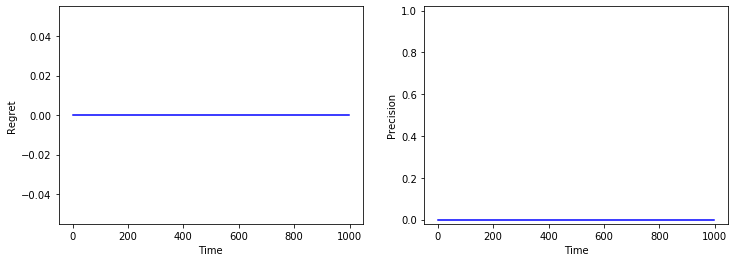

In [19]:
algo = algos[3]
results = simulate(model, model_param, time_horizon,  algo)
metrics = get_metrics(*results, *get_best_action(model, model_param))
show_metrics(metrics)

## Statistics

Finally, we provide some statistics on the performance of each algorithm for different time horizons.

**To do:**
* Compare the performance of the algorithms.
* What algorithm would you recommand for a time horizon $T = 1000$?

In [20]:
def get_stats(nb_samples, time_periods, model, model_param, algo):
    time_horizon = max(time_periods)
    norm_regret_samples = [[] for t in time_periods]
    precision_samples = [[] for t in time_periods]
    for s in range(nb_samples):
        results = simulate(model, model_param, time_horizon, algo)
        regret, precision = get_metrics(*results, *get_best_action(model, model_param))
        for i,t in enumerate(time_periods):
            norm_regret_samples[i].append(regret[t - 1] / t)
            precision_samples[i].append(precision[t - 1])
    return norm_regret_samples, precision_samples

In [21]:
def show_stats(time_periods, stats):
    meanprops = dict(marker='o', markeredgecolor='black', markerfacecolor='r')
    medianprops = dict(linestyle='-', linewidth=2.5, color = 'b')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
    ax1.boxplot(stats[0], positions = range(len(time_periods)), showfliers = False, showmeans = True, meanprops = meanprops, medianprops = medianprops)
    ax1.axhline(linestyle = '--', color = 'r')
    ax1.set_xticklabels(time_periods)
    ax1.set_xlabel('Time horizon')
    ax1.set_ylabel('Regret per action')
    ax2.boxplot(stats[1], positions = range(len(time_periods)), showfliers = False, showmeans = True, meanprops = meanprops, medianprops = medianprops)
    ax2.set_ylim(-0.02,1.02)
    ax2.axhline(y = 1, linestyle = '--', color = 'r')
    ax2.set_xticklabels(time_periods)
    ax2.set_xlabel('Time horizon')
    ax2.set_ylabel('Precision')
    plt.show()

In [22]:
time_periods = [100,1000,5000]
nb_samples = 100
model = "bernoulli"
model_param = [0.1, 0.2]
algo = algos[0]
stats = get_stats(nb_samples, time_periods, model, model_param, algo)

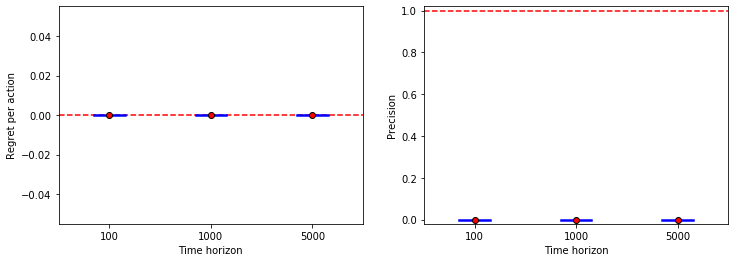

In [23]:
# mean as a red dot, median as a blue line
show_stats(time_periods, stats)